Data analysis for ionophoresis validation
============

In [1]:
import os
from timeit import default_timer as timer

import numpy as np
from numpy import ma

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import plotly.express as px
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import ListedColormap

from skimage.util import montage
from skimage.filters import rank
from skimage import morphology
from skimage import exposure
from skimage import measure
from skimage import segmentation
from skimage import filters
from skimage import feature
from skimage import io
from skimage import data, draw
from skimage.registration import phase_cross_correlation
from skimage import transform
from skimage.registration import optical_flow_tvl1, optical_flow_ilk

from scipy import ndimage as ndi
from scipy import signal
from scipy import stats
from scipy import optimize

from dipy.align.transforms import AffineTransform2D
from dipy.align.imaffine import AffineRegistration

import cv2

from domb.reg_type import wf_x2_m2 as wf
from domb.fret.e_fret.e_app import Eapp
from domb.red_green import wt_vs_mut_multistim
from domb.utils import plot
from domb.utils.plot import CMaps
from domb.utils import masking

#### Selected cells (Sasha)

__Ca dynamic__

Alexa + Fluo:
- 24_05_9_cell01 (5.5s|20s|34.5s, 90fr. 1 Hz) - for profile _REPRESENTATIVE MORPHOLOGY_
- 24_05_9_cell02 (5.5s|20s|34.5s, 90fr. 1 Hz) - for profile, bad decay

HPCA + Fluo:
- 24_05_8_cell7 (5.5s|20s|64.5s, 90fr. 1 Hz) - 25 mM! 2 cells, 1 bottom for profiles, up for max apm

- 24_05_24_cell_3_1 (25" 1 Hz) - 2 cells for profiles 
- 24_05_24_cell_2_1 (25" 1 Hz) - non transfected cell for max amp


__Cloud dymanic__

Alexa:
- 24_05_30_cell2-5 (5s|20s|35s 4x 1 Hz) - from-25 to -100 nA


__Not used__

Alexa:
- ? 24_06_07_cell1
- ? 24_06_07_cell2 w/o perfusion
- ? 24_06_07_cell3 w/o perfusion

HPCA + Fluo:
- 24_05_08_cell1 (100 mM)
- 24_05_08_cell6 (50 mM)
- 24_05_08_cell7 (25 mM)


# Area mask for representative cells

In [ ]:
path_list = ('/home/wisstock/bio_data/Sasha/ionophoresis/24_05_30/processing/01/24_05_30_cell1_ch1.tif',-+
             '/home/wisstock/bio_data/Sasha/ionophoresis/24_05_30/processing/02/24_05_30_cell2_ch1.tif',
             '/home/wisstock/bio_data/Sasha/ionophoresis/24_05_30/processing/03/24_05_30_cell3_ch1.tif',
             '/home/wisstock/bio_data/Sasha/ionophoresis/24_05_30/processing/04/24_05_30_cell4_ch1.tif',
             '/home/wisstock/bio_data/Sasha/ionophoresis/24_05_30/processing/05/24_05_30_cell5_ch1.tif')

alexa_arr = []

for path in path_list:
    alexa_arr.append(io.imread(path))

alexa_arr = np.array(alexa_arr)
alexa_arr.shape

(5, 240, 1040, 1392)

## Averaged peak cloud img

In [8]:
# max frame index
max_idx = np.argmax(np.mean(alexa_arr, axis=(2,3)), axis=1)
max_idx

array([205, 178, 178, 145, 120])

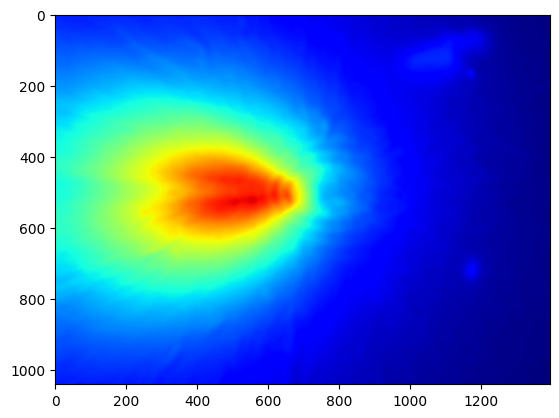

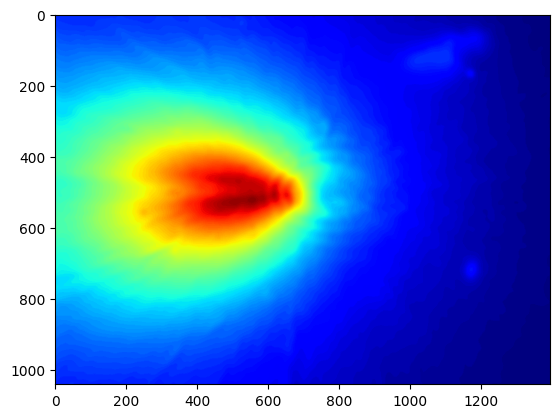

In [9]:
alexa_arr_max = alexa_arr[:,205,...]
alexa_arr_max = filters.gaussian(alexa_arr_max, sigma=8, channel_axis=0)
alexa_arr_max.shape

alexa_arr_max_norm = np.array([(f - np.min(f)) / (np.max(f) - np.min(f)) for f in alexa_arr_max], dtype=np.float64)
alexa_max_avg = np.mean(alexa_arr_max_norm, axis=0)

plt.imshow(alexa_max_avg, cmap='jet', vmax=1, vmin=0)
plt.show()

alexa_max_avg_norm = np.array(((alexa_max_avg - np.min(alexa_max_avg)) / (np.max(alexa_max_avg) - np.min(alexa_max_avg)))*100, dtype=np.uint16)
plt.imshow(alexa_max_avg_norm, cmap='jet', vmax=100, vmin=0)
plt.show()

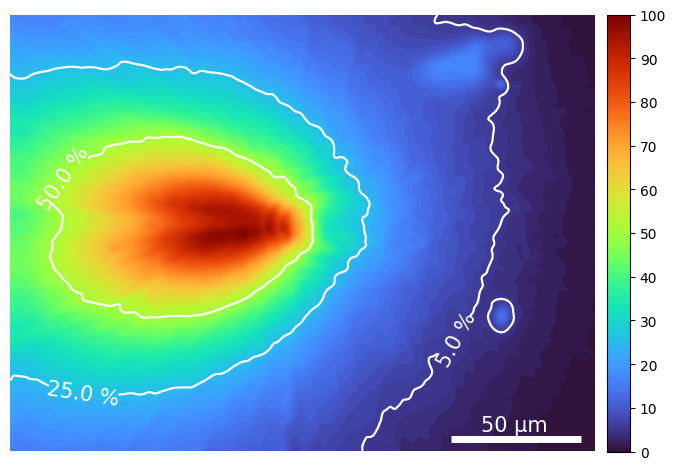

In [10]:
cmin,cmax = 0, 100

fig, ax0 = plt.subplots(figsize=(8,8))

img0 = ax0.imshow(alexa_max_avg_norm,
           cmap='turbo', vmin=cmin, vmax=cmax)
cs0 = ax0.contour(alexa_max_avg_norm, 
                  levels=[5, 25, 50], colors='w')
ax0.clabel(cs0, inline=True, fontsize=15, fmt = '%r %%')
ax0.text(x=1120,y=990,s='50 μm', color='w', size=15)
ax0.hlines(y=1010, xmin=1050, xmax=1358, linewidth=5, color='w')
ax0.set_axis_off()
ax0_div = make_axes_locatable(ax0)
cax0 = ax0_div.append_axes("right", size="4%", pad="2%")
cb0 = plt.colorbar(img0, cax0, ticks=range(0,110,10))


plt.show()

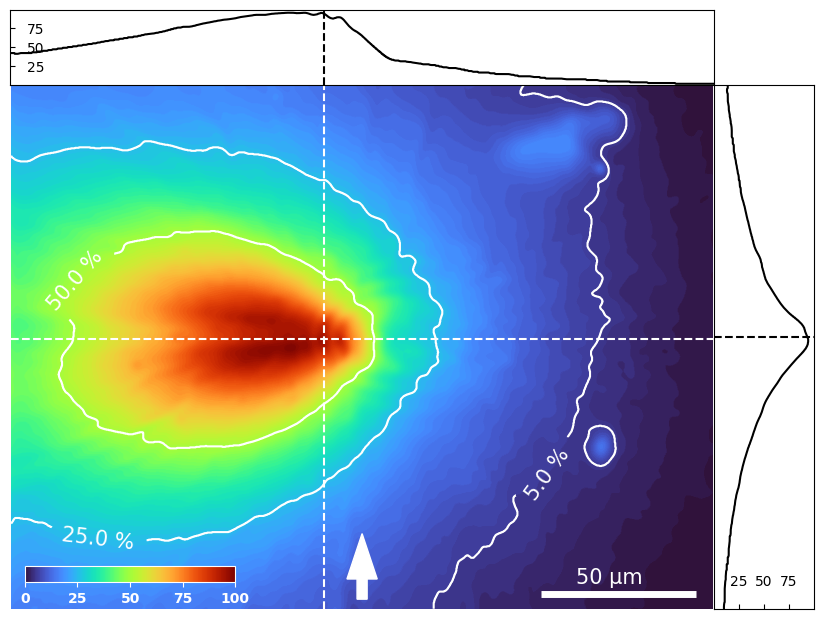

In [11]:
fig = plt.figure(figsize=(8.05, 6))
gs = fig.add_gridspec(2, 2,  width_ratios=(7, 1), height_ratios=(1, 7),
                      left=0.001, right=1, bottom=0.001, top=1,
                      wspace=0, hspace=0)
ax = fig.add_subplot(gs[1, 0])
img = ax.imshow(alexa_max_avg_norm, cmap='turbo', vmin=0, vmax=100)
ax.axvline(x=620, color='w', linestyle='--')
ax.axhline(y=505, color='w', linestyle='--')
cs = ax.contour(alexa_max_avg_norm, 
                levels=[5, 25, 50], colors='w')
ax.clabel(cs, inline=True, inline_spacing=15, fontsize=15, fmt = '%r %%')
axins = inset_axes(ax,
                   width="30%",  # width = 50% of parent_bbox width
                   height="3%",  # height : 5%
                   loc='upper left',
                   bbox_to_anchor=(0.01,-0.905,1,1), bbox_transform=ax.transAxes)
cb = fig.colorbar(img, cax=axins, orientation='horizontal',ticks=range(0,110,25))
cb.ax.xaxis.set_tick_params(color='white')
cb.ax.xaxis.set_ticks([0, 25, 50, 75, 100])
cb.outline.set_edgecolor('white')
plt.setp(plt.getp(cb.ax.axes, 'xticklabels'), color='white', weight='bold')
ax.set_axis_off()

ax.text(x=1120,y=990,s='50 μm', color='w', size=15)
ax.arrow(x=696, y=1020, dx=0, dy=-40, color='w', width=20)
ax.hlines(y=1010, xmin=1050, xmax=1358, linewidth=5, color='w')

ax_profx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_profx.plot(np.mean(alexa_max_avg_norm[500:511,:], axis=0), color='k')
ax_profx.axvline(x=620, color='k', linestyle='--')
ax_profx.set_xticks([])
ax_profx.set_yticks([25, 50, 75])
ax_profx.set_ylim(0, 100)
ax_profx.tick_params(axis="y",direction="in", pad=-25)

ax_profy = fig.add_subplot(gs[1, 1], sharey=ax)
ax_profy.plot(np.mean(alexa_max_avg_norm[:,610:631], axis=1), np.arange(0, alexa_max_avg_norm.shape[0],1), color='k')
ax_profy.axhline(y=500, color='k', linestyle='--')
ax_profy.set_yticks([])
ax_profy.set_xticks([25, 50, 75])
ax_profy.set_xlim(0, 100)
ax_profy.tick_params(axis="x",direction="in", pad=-25)

fig.savefig('alexa_map.png', dpi=300)

## Cloud mask

In [12]:
cloud_mask = np.digitize(alexa_max_avg_norm, bins=[0,5,25,50,100])
cloud_mask_split = np.copy(cloud_mask)
cloud_mask_split[:505,:] = cloud_mask[:505,:]*2
cloud_mask_split[cloud_mask == 4] = 7
cloud_mask_split[cloud_mask == 1] = 0  

np.unique(cloud_mask_split)

array([0, 2, 3, 4, 5, 6, 7])

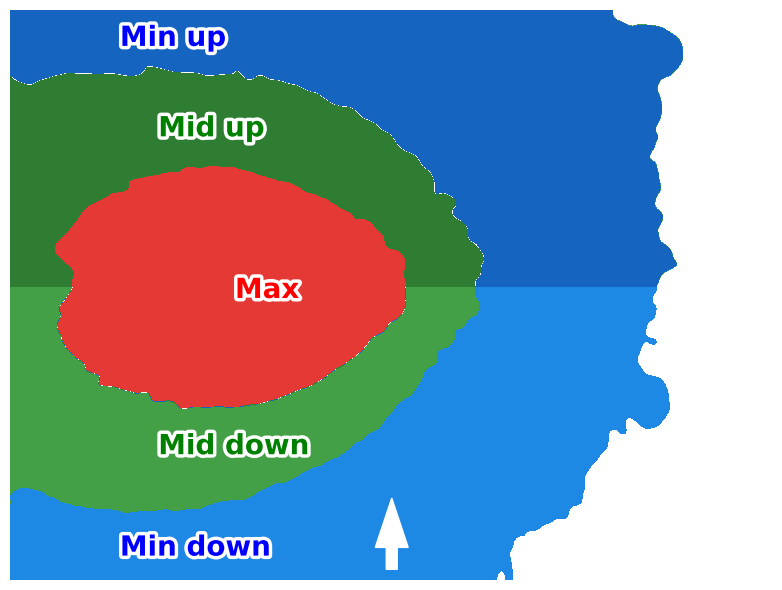

In [13]:
col_dict = {0: "white",    # back
            1: "white",    # border
            2: "#1e88e5",  # min down
            3: "#43a047",  # med down
            4: "#1565c0",  # min up
            5: "white",    # border
            6: "#2e7d32",  # med up
            7: "#e53935"}  # max
cm = ListedColormap([col_dict[x] for x in col_dict.keys()])


text_size = 20

fig, ax0 = plt.subplots(figsize=(8,6))
ax0.imshow(cloud_mask_split, cmap=cm)
ax0.text(x=200,y=65,s='Min up', color='b', size=text_size, weight='bold',
         path_effects=[patheffects.withStroke(linewidth=5, foreground='w', capstyle="round")])
ax0.text(x=270,y=230,s='Mid up', color='g', size=text_size, weight='bold',
         path_effects=[patheffects.withStroke(linewidth=5, foreground='w', capstyle="round")])
ax0.text(x=410,y=525,s='Max', color='r', size=text_size, weight='bold',
         path_effects=[patheffects.withStroke(linewidth=5, foreground='w', capstyle="round")])
ax0.text(x=270,y=810,s='Mid down', color='g', size=text_size, weight='bold',
         path_effects=[patheffects.withStroke(linewidth=5, foreground='w', capstyle="round")])
ax0.text(x=200,y=995,s='Min down', color='b', size=text_size, weight='bold',
         path_effects=[patheffects.withStroke(linewidth=5, foreground='w', capstyle="round")])
ax0.set_axis_off()
ax0.arrow(x=696, y=1020, dx=0, dy=-40, color='w', width=20)
plt.tight_layout()
plt.show()

# fig.savefig('zone_mask.png', dpi=300)
# io.imsave('zone_mask.tiff', cloud_mask_split)

# Calcium in representative cell

In [3]:
cell_img = io.imread('/home/wisstock/bio_data/Sasha/ionophoresis/24_05_9/processing/01/24_05_9_cell01_ch0.tif')
cell_img = cell_img[:,:,550:750]

cell_mask = io.imread('/home/wisstock/bio_data/Sasha/ionophoresis/24_05_9/processing/01/24_05_9_cell01_cell_mask.tif')
cell_mask = cell_mask[:,550:750].astype(bool)

In [7]:
fluo_pre = np.max(cell_img[0:5], axis=0)
fluo_max = np.max(cell_img[23:25], axis=0)
fluo_post = np.max(cell_img[53:55], axis=0)
fluo_stack = np.stack((fluo_pre, fluo_max, fluo_post), axis=0)

fluo_max_val = np.max(ma.masked_where(~cell_mask, fluo_max))
fluo_min_val = np.min(ma.masked_where(~cell_mask, fluo_pre))

print(fluo_max_val, fluo_min_val)
print(np.max(fluo_stack), np.min(fluo_stack))


fluo_stack_norm = (fluo_stack - np.min(fluo_stack)) / (np.max(fluo_stack) - np.min(fluo_stack))
print(np.max(fluo_stack_norm))
fluo_stack_norm = np.array(fluo_stack_norm*100, dtype=np.uint32)

3420 127
4140 19
1.0


In [48]:
df_max = np.divide((fluo_stack_norm[1] - fluo_stack_norm[0])+0.001, fluo_stack_norm[0]+0.001).clip(max=2)
df_max[~cell_mask] = 0.0

df_post = np.divide((fluo_stack_norm[2] - fluo_stack_norm[0])+0.001, fluo_stack_norm[0]+0.001).clip(max=0.5)
df_post[~cell_mask] = 0.0

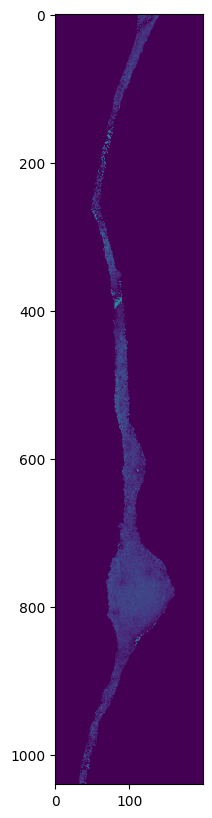

In [49]:
plt.figure(figsize=(10,10))
plt.imshow(df_post, vmin=0, vmax=1)

/tmp/ipykernel_10792/3305422993.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


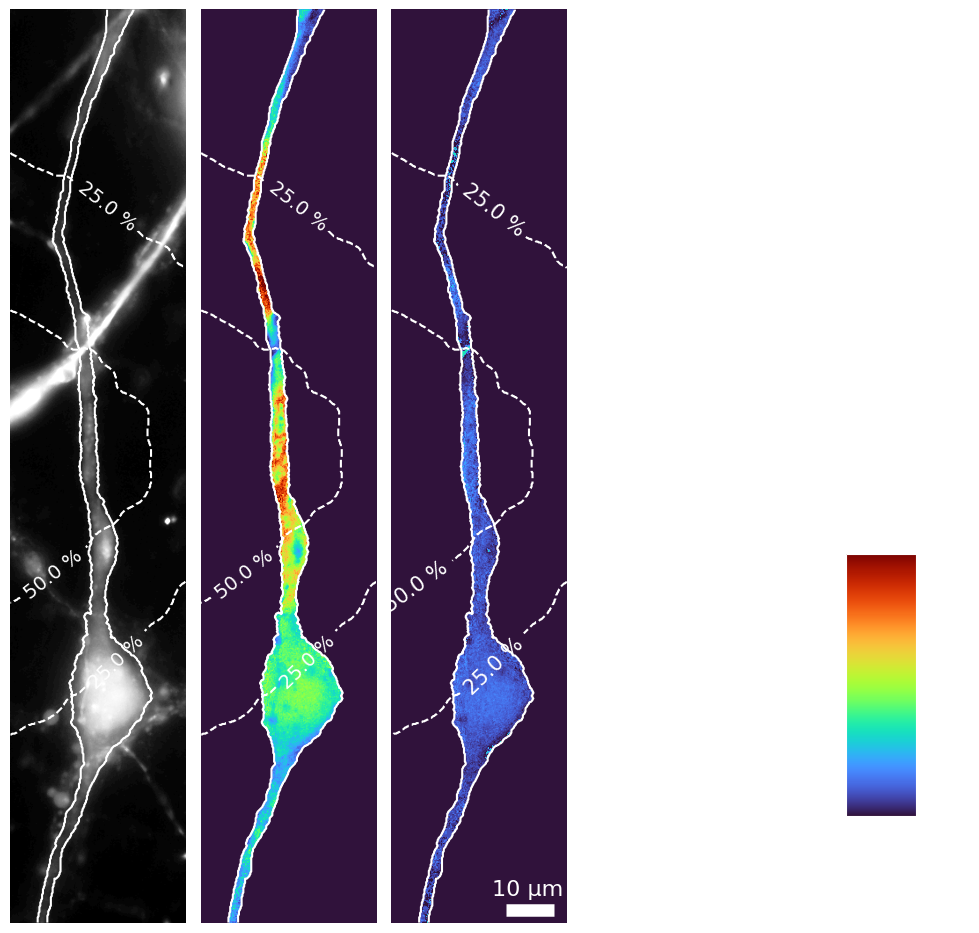

In [93]:
cmin,cmax = 0, 1.5

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(6,9.5))

img0 = ax0.imshow(fluo_stack_norm[0],
                  cmap='Greys_r', vmin=0, vmax=50)
ax0.contour(cell_mask, levels=[0], colors='w')
ax0.set_axis_off()
cs0 = ax0.contour(alexa_max_avg_norm[:,560:760], 
                  levels=[5, 25, 50], colors='w', linestyles='--')
ax0.clabel(cs0, inline=True, inline_spacing=0, fontsize=14, fmt = '%r %%')
# axins0 = inset_axes(ax0,
#                    width="60%",  # width = 50% of parent_bbox width
#                    height="7%",  # height : 5%
#                    loc='upper left',
#                    bbox_to_anchor=(0.11,-0.58,1,1), bbox_transform=ax.transAxes)
# cb0 = fig.colorbar(img0, cax=axins0, orientation='horizontal',ticks=range(0,110,25))
# cb0.ax.xaxis.set_tick_params(color='white')
# cb0.ax.xaxis.set_ticks([5, 25, 50, 75])
# cb0.outline.set_edgecolor('white')
# plt.setp(plt.getp(cb0.ax.axes, 'xticklabels'), color='white', fontsize=16)

img1 = ax1.imshow(df_max,
           cmap='turbo', vmin=cmin, vmax=cmax)
ax1.contour(cell_mask, levels=[0], colors='w')
cs1 = ax1.contour(alexa_max_avg_norm[:,560:760], 
                  levels=[5, 25, 50], colors='w', linestyles='--')
ax1.clabel(cs1, inline=True, inline_spacing=0, fontsize=14, fmt = '%r %%')
# ax1.arrow(x=100, y=1020, dx=0, dy=-40, color='w', width=10)
ax1.set_axis_off()
axins1 = inset_axes(ax1,
                   width="10%",  # width = 50% of parent_bbox width
                   height="50%",  # height : 5%
                   loc='upper left',
                   bbox_to_anchor=(1.2,-0.25,1,1), bbox_transform=ax.transAxes)
cb1 = fig.colorbar(img1, cax=axins1, orientation='vertical',ticks=range(0,110,25))
cb1.ax.yaxis.set_tick_params(color='white')
cb1.ax.yaxis.set_ticks([0, 0.75, 1.5])
cb1.outline.set_edgecolor('white')
plt.setp(plt.getp(cb1.ax.axes, 'yticklabels'), color='white', fontsize=14)


ax2.imshow(df_post,
           cmap='turbo', vmin=cmin, vmax=cmax)
ax2.contour(cell_mask, levels=[0], colors='w')
cs2 = ax2.contour(alexa_max_avg_norm[:,560:760], 
                  levels=[5, 25, 50], colors='w', linestyles='--')
ax2.clabel(cs2, inline=True, inline_spacing=0, fontsize=15, fmt = '%r %%')
ax2.text(x=114,y=1008,s='10 μm', color='w', size=16)
# ax2.arrow(x=100, y=1020, dx=0, dy=-40, color='w', width=10)
ax2.hlines(y=1025, xmin=130, xmax=184, linewidth=9, color='w')
ax2.set_axis_off()

plt.tight_layout()
fig.savefig('cell_pic.png', dpi=300)

# Old representative

## Spatial profiles

In [3]:
raw_img = io.imread('/home/wisstock/bio_data/chemLTD/Sasha/24_05_9/24_05_9_cell01.tif')
cell_mask = io.imread('/home/wisstock/bio_data/chemLTD/Sasha/24_05_9/01/24_05_9_cell01_0-60_ch0_red-green_up-labels.tif')
cell_mask.shape

(1040, 1392)

### Alexa pre-max-post img full-frame

In [4]:
alexa_pre = np.max(raw_img[2:5,1,...], axis=0)
alexa_max = np.max(raw_img[23:26,1,...], axis=0)
alexa_post = np.max(raw_img[44:46,1,...], axis=0)

alexa_stack = np.stack((alexa_pre, alexa_max, alexa_post), axis=0)
alexa_stack = filters.gaussian(alexa_stack, sigma=25, channel_axis=0)
alexa_stack.shape
alexa_stack_norm = (alexa_stack - np.min(alexa_stack)) / (np.max(alexa_stack) - np.min(alexa_stack))
alexa_stack_norm = np.array(alexa_stack_norm*100, dtype=np.uint8)

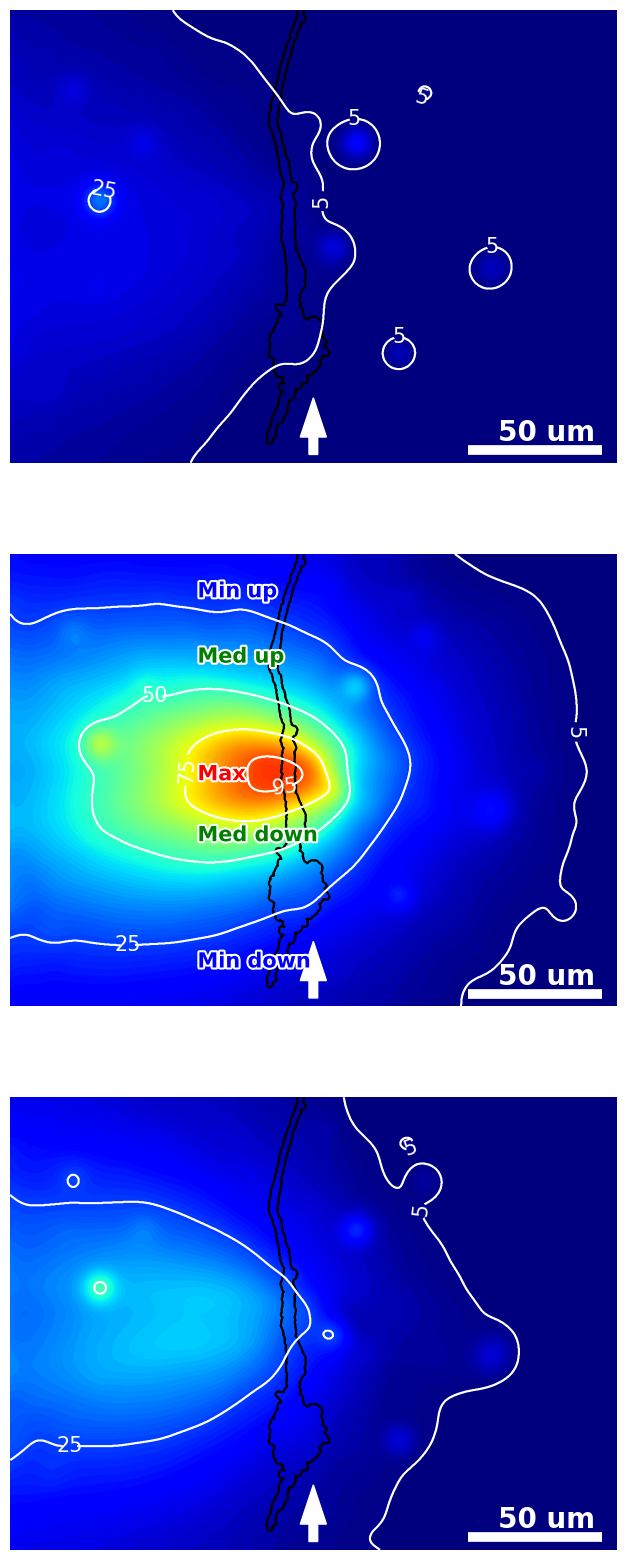

In [45]:
cmin,cmax = 5, 115

fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(20,20))

ax0.imshow(alexa_stack_norm[0],
           cmap='jet', vmin=cmin, vmax=cmax)
ax0.contour(cell_mask, levels=[0], colors='k')
cs0 = ax0.contour(alexa_stack_norm[0], 
                levels=[5, 25, 50, 75, 95], colors='w')
ax0.clabel(cs0, inline=True, fontsize=15)
ax0.text(x=1120,y=990,s='50 um', color='w', size=20, weight='bold')
ax0.arrow(x=696, y=1020, dx=0, dy=-40, color='w', width=20)
ax0.hlines(y=1010, xmin=1050, xmax=1358, linewidth=7, color='w')
ax0.set_axis_off()

ax1.imshow(alexa_stack_norm[1],
           cmap='jet', vmin=cmin, vmax=cmax)
ax1.contour(cell_mask, levels=[0], colors='k')
cs1 = ax1.contour(alexa_stack_norm[1], 
                levels=[5, 25, 50, 75, 95], colors='w')
ax1.clabel(cs1, inline=True, fontsize=15)
ax1.text(x=430,y=100,s='Min up', color='b', size=15, weight='bold',
         path_effects=[patheffects.withStroke(linewidth=3, foreground='w', capstyle="round")])
ax1.text(x=430,y=250,s='Med up', color='g', size=15, weight='bold',
         path_effects=[patheffects.withStroke(linewidth=3, foreground='w', capstyle="round")])
ax1.text(x=430,y=520,s='Max', color='r', size=15, weight='bold',
         path_effects=[patheffects.withStroke(linewidth=3, foreground='w', capstyle="round")])
ax1.text(x=430,y=660,s='Med down', color='g', size=15, weight='bold',
         path_effects=[patheffects.withStroke(linewidth=3, foreground='w', capstyle="round")])
ax1.text(x=430,y=950,s='Min down', color='b', size=15, weight='bold',
         path_effects=[patheffects.withStroke(linewidth=3, foreground='w', capstyle="round")])
ax1.text(x=1120,y=990,s='50 um', color='w', size=20, weight='bold')
ax1.arrow(x=696, y=1020, dx=0, dy=-40, color='w', width=20)
ax1.hlines(y=1010, xmin=1050, xmax=1358, linewidth=7, color='w')
ax1.set_axis_off()

ax2.imshow(alexa_stack_norm[2],
           cmap='jet', vmin=cmin, vmax=cmax)
ax2.contour(cell_mask, levels=[0], colors='k')
cs2 = ax2.contour(alexa_stack_norm[2], 
                levels=[5, 25, 50, 75, 95], colors='w')
ax2.clabel(cs2, inline=True, fontsize=15)
ax2.text(x=1120,y=990,s='50 um', color='w', size=20, weight='bold')
ax2.arrow(x=696, y=1020, dx=0, dy=-40, color='w', width=20)
ax2.hlines(y=1010, xmin=1050, xmax=1358, linewidth=7, color='w')
ax2.set_axis_off()

plt.savefig('alexa_contours.png', dpi=300)

### Fluo pre-max-post img full-frame

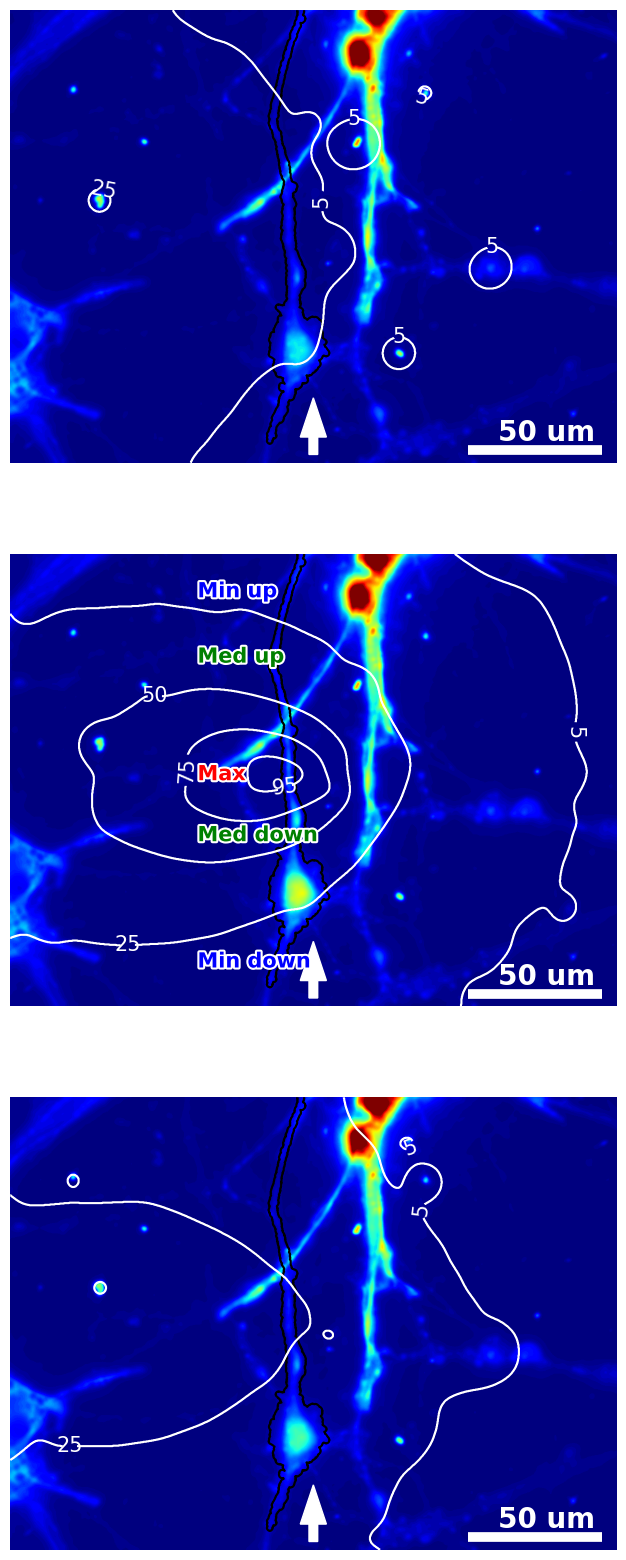

In [46]:
fluo_pre = np.max(raw_img[2:5,0,...], axis=0)
fluo_max = np.max(raw_img[23:26,0,...], axis=0)
fluo_post = np.max(raw_img[44:46,0,...], axis=0)

fluo_stack = np.stack((fluo_pre, fluo_max, fluo_post), axis=0)
fluo_stack = filters.gaussian(fluo_stack, sigma=3, channel_axis=0)
fluo_stack.shape
fluo_stack_norm = (fluo_stack - np.min(fluo_stack)) / (np.max(fluo_stack) - np.min(fluo_stack))
fluo_stack_norm = np.array(fluo_stack_norm*100, dtype=np.uint8)


cmin,cmax = 0, 75

fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(20,20))

ax0.imshow(fluo_stack_norm[0],
           cmap='jet', vmin=cmin, vmax=cmax)
ax0.contour(cell_mask, levels=[0], colors='k')
cs0 = ax0.contour(alexa_stack_norm[0], 
                levels=[5, 25, 50, 75, 95], colors='w')
ax0.clabel(cs0, inline=True, fontsize=15)
ax0.text(x=1120,y=990,s='50 um', color='w', size=20, weight='bold')
ax0.arrow(x=696, y=1020, dx=0, dy=-40, color='w', width=20)
ax0.hlines(y=1010, xmin=1050, xmax=1358, linewidth=7, color='w')
ax0.set_axis_off()

ax1.imshow(fluo_stack_norm[1],
           cmap='jet', vmin=cmin, vmax=cmax)
ax1.contour(cell_mask, levels=[0], colors='k')
cs1 = ax1.contour(alexa_stack_norm[1], 
                levels=[5, 25, 50, 75, 95], colors='w')
ax1.clabel(cs1, inline=True, fontsize=15)

ax1.text(x=430,y=100,s='Min up', color='b', size=15, weight='bold',
         path_effects=[patheffects.withStroke(linewidth=3, foreground='w', capstyle="round")])
ax1.text(x=430,y=250,s='Med up', color='g', size=15, weight='bold',
         path_effects=[patheffects.withStroke(linewidth=3, foreground='w', capstyle="round")])
ax1.text(x=430,y=520,s='Max', color='r', size=15, weight='bold',
         path_effects=[patheffects.withStroke(linewidth=3, foreground='w', capstyle="round")])
ax1.text(x=430,y=660,s='Med down', color='g', size=15, weight='bold',
         path_effects=[patheffects.withStroke(linewidth=3, foreground='w', capstyle="round")])
ax1.text(x=430,y=950,s='Min down', color='b', size=15, weight='bold',
         path_effects=[patheffects.withStroke(linewidth=3, foreground='w', capstyle="round")])

ax1.text(x=1120,y=990,s='50 um', color='w', size=20, weight='bold')
ax1.arrow(x=696, y=1020, dx=0, dy=-40, color='w', width=20)
ax1.hlines(y=1010, xmin=1050, xmax=1358, linewidth=7, color='w')
ax1.set_axis_off()

ax2.imshow(fluo_stack_norm[2],
           cmap='jet', vmin=cmin, vmax=cmax)
ax2.contour(cell_mask, levels=[0], colors='k')
cs2 = ax2.contour(alexa_stack_norm[2], 
                levels=[5, 25, 50, 75, 95], colors='w')
ax2.clabel(cs2, inline=True, fontsize=15)
ax2.text(x=1120,y=990,s='50 um', color='w', size=20, weight='bold')
ax2.arrow(x=696, y=1020, dx=0, dy=-40, color='w', width=20)
ax2.hlines(y=1010, xmin=1050, xmax=1358, linewidth=7, color='w')
ax2.set_axis_off()

plt.savefig('fluo_contours.png', dpi=300)

### Fluo pre-max-post img

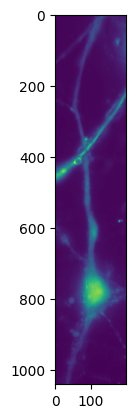

In [83]:
plt.imshow(np.max(raw_img[23:26,0,:,550:750], axis=0))

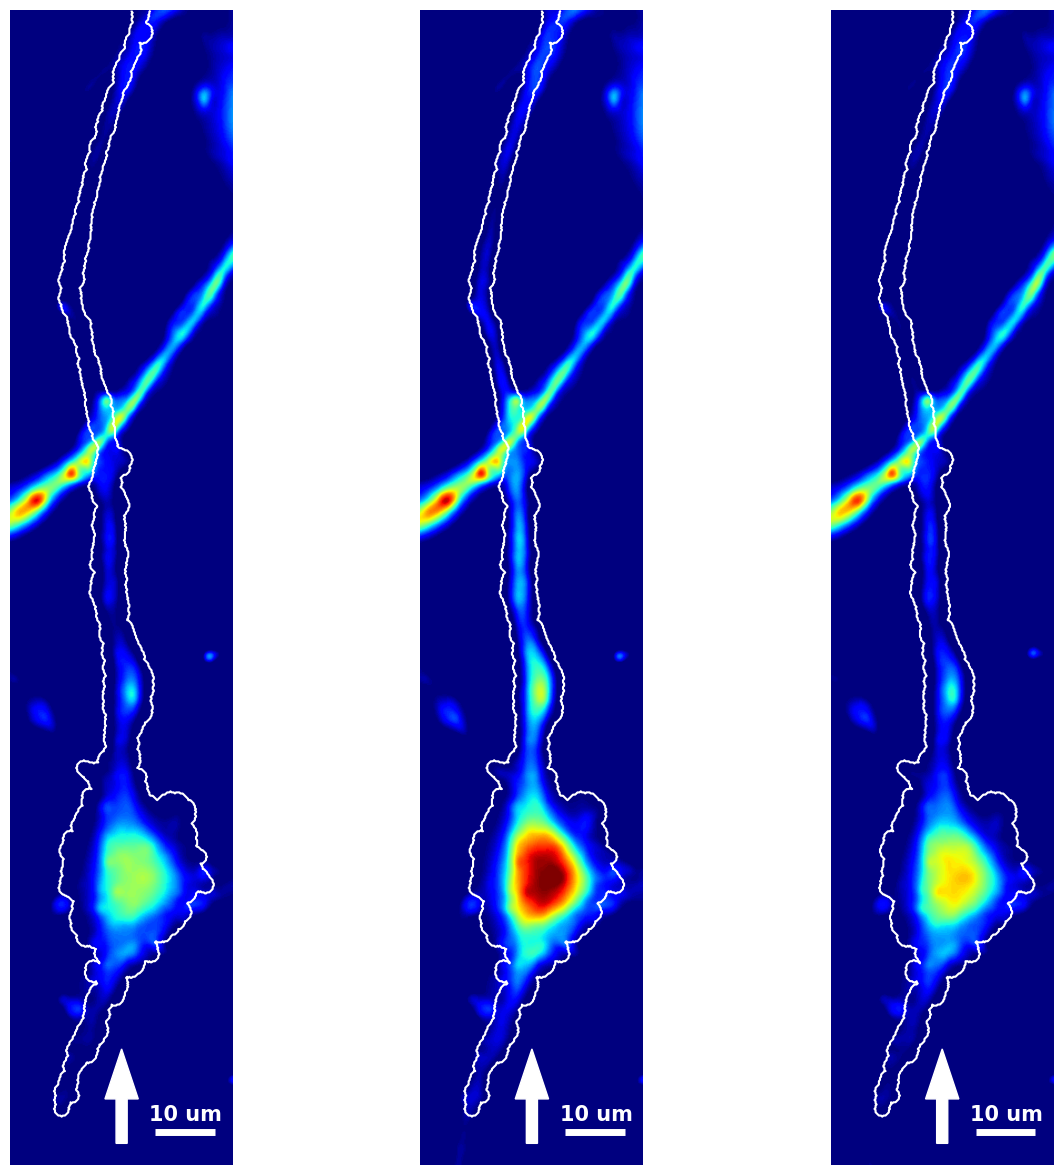

In [112]:
fluo_pre = np.max(raw_img[2:5,0,:,550:750], axis=0)
fluo_max = np.max(raw_img[23:26,0,:,550:750], axis=0)
fluo_post = np.max(raw_img[44:46,0,:,550:750], axis=0)

fluo_stack = np.stack((fluo_pre, fluo_max, fluo_post), axis=0)
fluo_stack = filters.gaussian(fluo_stack, sigma=3, channel_axis=0)
fluo_stack.shape
fluo_stack_norm = (fluo_stack - np.min(fluo_stack)) / (np.max(fluo_stack) - np.min(fluo_stack))
fluo_stack_norm = np.array(fluo_stack_norm*100, dtype=np.uint8)


cmin,cmax = 10, 95

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(15,15))

ax0.imshow(fluo_stack_norm[0],
           cmap='jet', vmin=cmin, vmax=cmax)
ax0.contour(cell_mask[:, 550:750], levels=[0], colors='w')
ax0.text(x=125,y=1000,s='10 um', color='w', size=15, weight='bold')
ax0.arrow(x=100, y=1020, dx=0, dy=-40, color='w', width=10)
ax0.hlines(y=1010, xmin=130, xmax=184, linewidth=5, color='w')
ax0.set_axis_off()

ax1.imshow(fluo_stack_norm[1],
           cmap='jet', vmin=cmin, vmax=cmax)
ax1.contour(cell_mask[:, 550:750], levels=[0], colors='w')
ax1.text(x=125,y=1000,s='10 um', color='w', size=15, weight='bold')
ax1.arrow(x=100, y=1020, dx=0, dy=-40, color='w', width=10)
ax1.hlines(y=1010, xmin=130, xmax=184, linewidth=5, color='w')
ax1.set_axis_off()

ax2.imshow(fluo_stack_norm[2],
           cmap='jet', vmin=cmin, vmax=cmax)
ax2.contour(cell_mask[:, 550:750], levels=[0], colors='w')
ax2.text(x=125,y=1000,s='10 um', color='w', size=15, weight='bold')
ax2.arrow(x=100, y=1020, dx=0, dy=-40, color='w', width=10)
ax2.hlines(y=1010, xmin=130, xmax=184, linewidth=5, color='w')
ax2.set_axis_off()


plt.savefig('fluo_contours.png', dpi=300)


In [88]:
fluo_pre.shape

(1040, 200)

### Alexa max with profiles

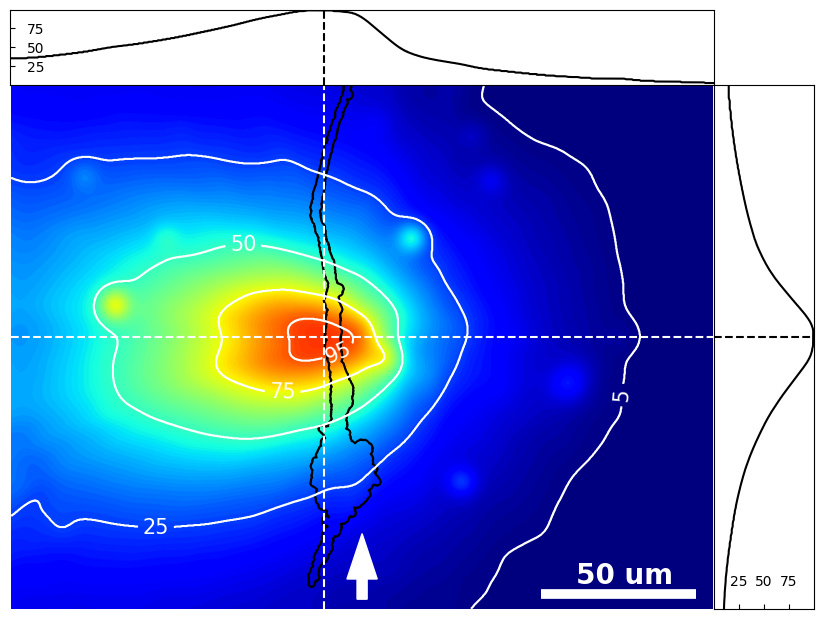

In [3]:
alexa_avg_max_img = np.max(raw_img[20:26,1,...], axis=0)
alexa_filtered = filters.gaussian(alexa_avg_max_img, sigma=20)
alexa_norm = (alexa_filtered - np.min(alexa_filtered)) / (np.max(alexa_filtered) - np.min(alexa_filtered))

alexa_norm = np.asarray(alexa_norm * 100, dtype=np.int8)
alexa_bin = np.digitize(alexa_norm, bins=[0, 5, 25, 50, 75, 95])

fig = plt.figure(figsize=(8.05, 6))
gs = fig.add_gridspec(2, 2,  width_ratios=(7, 1), height_ratios=(1, 7),
                      left=0.001, right=1, bottom=0.001, top=1,
                      wspace=0, hspace=0)
ax = fig.add_subplot(gs[1, 0])
ax.imshow(alexa_norm, cmap='jet', vmin=5, vmax=115)
ax.contour(cell_mask, levels=[0], colors='k')
ax.axvline(x=620, color='w', linestyle='--')
ax.axhline(y=500, color='w', linestyle='--')
cs = ax.contour(alexa_norm, 
                levels=[5, 25, 50, 75, 95], colors='w')
ax.clabel(cs, inline=True, fontsize=15)
ax.set_axis_off()

ax.text(x=1120,y=990,s='50 um', color='w', size=20, weight='bold')
ax.arrow(x=696, y=1020, dx=0, dy=-40, color='w', width=20)
ax.hlines(y=1010, xmin=1050, xmax=1358, linewidth=7, color='w')

ax_profx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_profx.plot(np.mean(alexa_norm[490:511,:], axis=0), color='k')
ax_profx.axvline(x=620, color='k', linestyle='--')
ax_profx.set_xticks([])
ax_profx.set_yticks([25, 50, 75])
ax_profx.set_ylim(0, 100)
ax_profx.tick_params(axis="y",direction="in", pad=-25)

ax_profy = fig.add_subplot(gs[1, 1], sharey=ax)
ax_profy.plot(np.mean(alexa_norm[:,610:631], axis=1), np.arange(0, alexa_norm.shape[0],1), color='k')
ax_profy.axhline(y=500, color='k', linestyle='--')
ax_profy.set_yticks([])
ax_profy.set_xticks([25, 50, 75])
ax_profy.set_xlim(0, 100)
ax_profy.tick_params(axis="x",direction="in", pad=-25)

fig.savefig('alexa_map.png', dpi=300)

In [170]:
norm = lambda a,max,min: (a-min)/(max-min)

prof_100 = np.flip(np.mean(np.max(raw_img[20:26, 1, ...], axis=0)[:,610:631], axis=1))
norm_100 = norm(prof_100, np.max(prof_100), np.min(prof_100))
prof_75 = np.flip(np.mean(np.max(raw_img[80:85, 1, ...], axis=0)[:,610:631], axis=1) )
norm_75 = norm(prof_75, np.max(prof_100), np.min(prof_100))
prof_50 = np.flip(np.mean(np.max(raw_img[140:145, 1, ...], axis=0)[:,610:631], axis=1))
norm_50 = norm(prof_50, np.max(prof_100), np.min(prof_100))
prof_25 = np.flip(np.mean(np.max(raw_img[200:204, 1, ...], axis=0)[:,610:631], axis=1))
norm_25 = norm(prof_25, np.max(prof_100), np.min(prof_100))

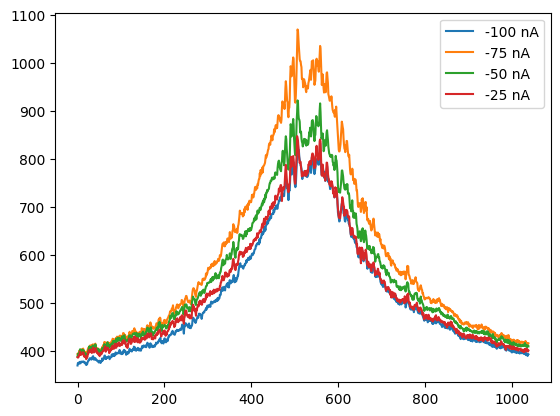

In [171]:
plt.plot(prof_100, label='-100 nA')
plt.plot(prof_75, label='-75 nA')
plt.plot(prof_50, label='-50 nA')
plt.plot(prof_25, label='-25 nA')
plt.legend()

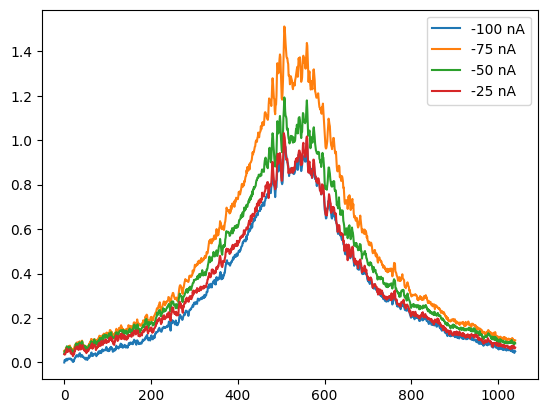

In [173]:
plt.plot(norm_100, label='-100 nA')
plt.plot(norm_75, label='-75 nA')
plt.plot(norm_50, label='-50 nA')
plt.plot(norm_25, label='-25 nA')
plt.legend()

## Temporal profile

### -100 nA

In [115]:
def df_to_stat(path, norm=False):
    df = pd.read_csv(path)
    arr = np.asarray(df.groupby('roi').int.apply(np.array).reset_index()['int'])
    arr = np.array([row for row in arr])
    if norm:
        arr_norm = (arr - np.min(arr))/(np.max(arr) - np.min(arr))
        return np.stack((np.mean(arr_norm, axis=0), np.std(arr_norm, axis=0)), axis=0)
    else:
        return np.stack((np.mean(arr, axis=0), np.std(arr, axis=0)), axis=0)

fluo_max = df_to_stat('/home/wisstock/bio_data/chemLTD/Sasha/24_05_9/01/cell_1_1_zone max.csv')
fluo_med_up = df_to_stat('/home/wisstock/bio_data/chemLTD/Sasha/24_05_9/01/cell_1_1_zone med up.csv')
fluo_med_down = df_to_stat('/home/wisstock/bio_data/chemLTD/Sasha/24_05_9/01/cell_1_1_zone med down.csv')
fluo_min_up = df_to_stat('/home/wisstock/bio_data/chemLTD/Sasha/24_05_9/01/cell_1_1_zone min up.csv')
fluo_min_down = df_to_stat('/home/wisstock/bio_data/chemLTD/Sasha/24_05_9/01/cell_1_1_zone min down.csv')

alexa_max = df_to_stat('/home/wisstock/bio_data/chemLTD/Sasha/24_05_9/01/cell_1_1_alexa_max.csv')
alexa_med_up = df_to_stat('/home/wisstock/bio_data/chemLTD/Sasha/24_05_9/01/cell_1_1_alexa_med_up.csv')
alexa_med_down = df_to_stat('/home/wisstock/bio_data/chemLTD/Sasha/24_05_9/01/cell_1_1_alexa_med_down.csv')
alexa_min_up = df_to_stat('/home/wisstock/bio_data/chemLTD/Sasha/24_05_9/01/cell_1_1_alexa_min_up.csv')
alexa_min_down = df_to_stat('/home/wisstock/bio_data/chemLTD/Sasha/24_05_9/01/cell_1_1_alexa_min_down.csv')

time_line = np.arange(0,60,1)

### -25 nA

In [229]:
# def df_to_stat(path, norm=False):
#     df = pd.read_csv(path)
#     arr = np.asarray(df.groupby('roi').int.apply(np.array).reset_index()['int'])
#     arr = np.array([row for row in arr])
#     if norm:
#         arr_norm = (arr - np.min(arr))/(np.max(arr) - np.min(arr))
#         return np.stack((np.mean(arr_norm, axis=0), np.std(arr_norm, axis=0)), axis=0)
#     else:
#         return np.stack((np.mean(arr, axis=0), np.std(arr, axis=0)), axis=0)

# fluo_max = df_to_stat('/home/wisstock/bio_data/chemLTD/Sasha/24_05_9/01/cell_1_4_zone max.csv')
# fluo_med_up = df_to_stat('/home/wisstock/bio_data/chemLTD/Sasha/24_05_9/01/cell_1_4_zone med up.csv')
# fluo_med_down = df_to_stat('/home/wisstock/bio_data/chemLTD/Sasha/24_05_9/01/cell_1_4_zone med down.csv')
# fluo_min_up = df_to_stat('/home/wisstock/bio_data/chemLTD/Sasha/24_05_9/01/cell_1_4_zone min up.csv')
# fluo_min_down = df_to_stat('/home/wisstock/bio_data/chemLTD/Sasha/24_05_9/01/cell_1_4_zone min down.csv')

# alexa_max = df_to_stat('/home/wisstock/bio_data/chemLTD/Sasha/24_05_9/01/cell_1_4_alexa_max.csv')
# alexa_med_up = df_to_stat('/home/wisstock/bio_data/chemLTD/Sasha/24_05_9/01/cell_1_4_alexa_med_up.csv')
# alexa_med_down = df_to_stat('/home/wisstock/bio_data/chemLTD/Sasha/24_05_9/01/cell_1_4_alexa_med_down.csv')
# alexa_min_up = df_to_stat('/home/wisstock/bio_data/chemLTD/Sasha/24_05_9/01/cell_1_4_alexa_min_up.csv')
# alexa_min_down = df_to_stat('/home/wisstock/bio_data/chemLTD/Sasha/24_05_9/01/cell_1_4_alexa_min_down.csv')

# time_line = np.arange(0,60,1)

### Plot

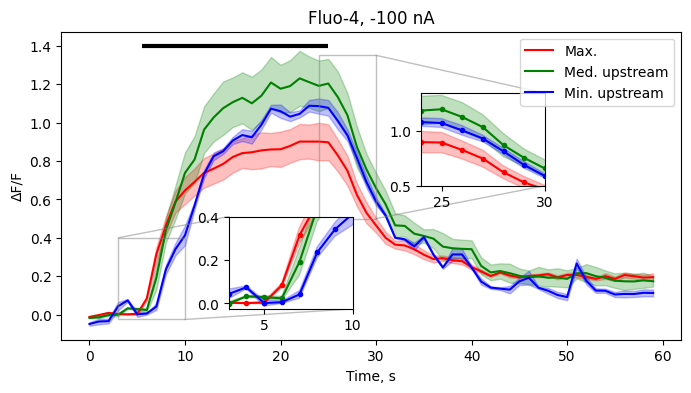

In [121]:
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(time_line, fluo_max[0], color='red', label='Max.')
ax.fill_between(x=time_line, y1=fluo_max[0]+fluo_max[1], y2=fluo_max[0]-fluo_max[1],
                 alpha=.25, color='red')
ax.plot(time_line, fluo_med_up[0], color='green', label='Med. upstream')
ax.fill_between(x=time_line, y1=fluo_med_up[0]+fluo_med_up[1], y2=fluo_med_up[0]-fluo_med_up[1],
                 alpha=.25, color='green')
ax.plot(time_line, fluo_min_up[0], color='blue', label='Min. upstream')
ax.fill_between(x=time_line, y1=fluo_min_up[0]+fluo_min_up[1], y2=fluo_min_up[0]-fluo_min_up[1],
                 alpha=.25, color='blue')
ax.hlines(y=1.4, xmin=5.5, xmax=25, color='k', linewidth=3)

axins = ax.inset_axes([0.27, 0.1, 0.2, 0.3])
axins.plot(time_line, fluo_max[0], color='red', label='Max.', marker='.')
axins.fill_between(x=time_line, y1=fluo_max[0]+fluo_max[1], y2=fluo_max[0]-fluo_max[1],
                   alpha=.25, color='red')
axins.plot(time_line, fluo_med_up[0], color='green', label='Med. upstream', marker='.')
axins.fill_between(x=time_line, y1=fluo_med_up[0]+fluo_med_up[1], y2=fluo_med_up[0]-fluo_med_up[1],
                 alpha=.25, color='green')
axins.plot(time_line, fluo_min_up[0], color='blue', label='Min. upstream', marker='.')
axins.fill_between(x=time_line, y1=fluo_min_up[0]+fluo_min_up[1], y2=fluo_min_up[0]-fluo_min_up[1],
                 alpha=.25, color='blue')
x1, x2, y1, y2 = 3, 10, -0.025, 0.4
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
# axins.set_yticks([])

axins2 = ax.inset_axes([0.58, 0.5, 0.2, 0.3])
axins2.plot(time_line, fluo_max[0], color='red', label='Max.', marker='.')
axins2.fill_between(x=time_line, y1=fluo_max[0]+fluo_max[1], y2=fluo_max[0]-fluo_max[1],
                   alpha=.25, color='red')
axins2.plot(time_line, fluo_med_up[0], color='green', label='Med. upstream', marker='.')
axins2.fill_between(x=time_line, y1=fluo_med_up[0]+fluo_med_up[1], y2=fluo_med_up[0]-fluo_med_up[1],
                 alpha=.25, color='green')
axins2.plot(time_line, fluo_min_up[0], color='blue', label='Min. upstream', marker='.')
axins2.fill_between(x=time_line, y1=fluo_min_up[0]+fluo_min_up[1], y2=fluo_min_up[0]-fluo_min_up[1],
                 alpha=.25, color='blue')
x1, x2, y1, y2 = 24, 30, 0.5, 1.35
axins2.set_xlim(x1, x2)
axins2.set_ylim(y1, y2)

ax.indicate_inset_zoom(axins)
ax.indicate_inset_zoom(axins2)

plt.title('Fluo-4, -100 nA')
plt.xlabel('Time, s')
plt.ylabel('ΔF/F')
plt.legend(loc=1)

fig.savefig('fluo_prof.png', dpi=300)

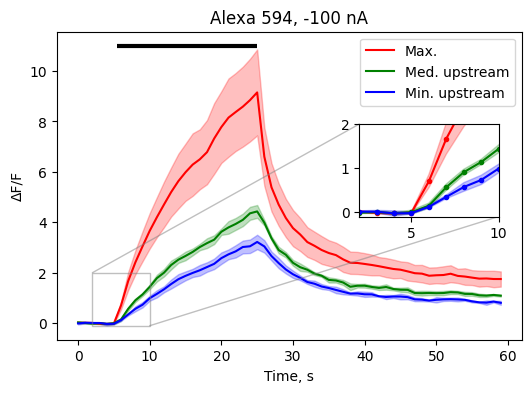

In [120]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(time_line, alexa_max[0], color='red', label='Max.')
ax.fill_between(x=time_line, y1=alexa_max[0]+alexa_max[1], y2=alexa_max[0]-alexa_max[1],
                 alpha=.25, color='red')
ax.plot(time_line, alexa_med_up[0], color='green', label='Med. upstream')
ax.fill_between(x=time_line, y1=alexa_med_up[0]+alexa_med_up[1], y2=alexa_med_up[0]-alexa_med_up[1],
                 alpha=.25, color='green')
ax.plot(time_line, alexa_min_up[0], color='blue', label='Min. upstream')
ax.fill_between(x=time_line, y1=alexa_min_up[0]+alexa_min_up[1], y2=alexa_min_up[0]-alexa_min_up[1],
                 alpha=.25, color='blue')
ax.hlines(y=11, xmin=5.5, xmax=25, color='k', linewidth=3)

axins = ax.inset_axes([0.65, 0.4, 0.3, 0.3])
axins.plot(time_line, alexa_max[0], color='red', label='Max.', marker='.')
axins.fill_between(x=time_line, y1=alexa_max[0]+alexa_max[1], y2=alexa_max[0]-alexa_max[1],
                   alpha=.25, color='red')
axins.plot(time_line, alexa_med_up[0], color='green', label='Med. upstream', marker='.')
axins.fill_between(x=time_line, y1=alexa_med_up[0]+alexa_med_up[1], y2=alexa_med_up[0]-alexa_med_up[1],
                 alpha=.25, color='green')
axins.plot(time_line, alexa_min_up[0], color='blue', label='Min. upstream', marker='.')
axins.fill_between(x=time_line, y1=alexa_min_up[0]+alexa_min_up[1], y2=alexa_min_up[0]-alexa_min_up[1],
                 alpha=.25, color='blue')
x1, x2, y1, y2 = 2, 10, -0.1, 2
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
# axins.set_yticks([])

ax.indicate_inset_zoom(axins)

plt.title('Alexa 594, -100 nA')
plt.xlabel('Time, s')
plt.ylabel('ΔF/F')
plt.legend()

fig.savefig('alexa_prof_2.png', dpi=300)